In [1]:
# !pip install -U --pre jaxlib -f https://storage.googleapis.com/jax-releases/jaxlib_nightly_cuda12_releases.html
# !pip install -U --pre jax -f https://storage.googleapis.com/jax-releases/jax_nightly_releases.html
# !pip install torch transformers matplotlib seaborn

In [29]:
from transformers import (
    OPTForCausalLM, 
)

import jax.numpy as jnp
from jax import random
import torch
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()
from collections import defaultdict
from scipy.linalg import block_diag

In [30]:
def decomposition_vector(x, iter, orth='qr', seed=42):
    
    x_0 = x.copy()
    n = len(x)

    np.random.seed(seed)
    key = random.PRNGKey(seed)

    u, v = jnp.zeros(n), jnp.zeros(n)

    if orth == 'qr':
      Q, _ = jnp.linalg.qr(random.normal(key, shape=(n, n)))

    else:
      raise ValueError('Invalid orthogonal matrix type')

    print(x.shape, Q.shape)

    story = []

    while iter > 0:
      word, word_ = jnp.sign(x), jnp.sign(Q.T @ x)
      fac = (jnp.dot(word, x) > jnp.dot(word_, Q.T @ x))

      if fac:
          pass
      else:
          word = Q @ word_

      # why np.linalg.norm leads to fail in convergence?
      word /= jnp.linalg.norm(word)
      # word /= np.linalg.norm(word).astype(np.float)

      coef = (x @ word)
      x -= coef * word

      if fac:
          u += coef * word
      else:
          v += coef * word

      iter -= 1

      story.append(jnp.linalg.norm(x_0 - u - v).item())

    return x, u, v, Q, story


In [36]:
def generate_dct(N):
    # Create a matrix of indices for rows and columns
    i, j = jnp.meshgrid(jnp.arange(N), jnp.arange(N), indexing='ij')
    
    # Compute the first column separately (it has a unique formula)
    first_col = jnp.ones((N, 1)) * (1 / jnp.sqrt(N))
    
    # Compute the rest of the matrix
    rest = jnp.sqrt(2 / N) * jnp.cos(jnp.pi * (2 * i + 1) * j / (2 * N))
    
    # Combine the first column with the rest, note the first column is repeated N times, but we only need it once
    Q = jnp.hstack((first_col, rest[:, 1:]))
    
    return Q

def generate_givens(key, n):
  i, j = random.choice(key, a=jnp.arange(n), shape=(2,), replace=False)
  th = random.uniform(key, minval=0, maxval=2*jnp.pi)

  c, s = jnp.cos(th), jnp.sin(th)
  Q = jnp.eye(n)
  Q.at[i,i].set(c)
  Q.at[i,j].set(-s)
  Q.at[j,j].set(c)
  Q.at[j,i].set(s)

  return Q

NQ = 3

def butterfly_generating_vector(n):
    '''
    Generates a vector `u` used to construct random butterfly orthogonal
        matrices.

    Args:
    =====
    n: size of generating vector, n = N + 1 to construct random
        butterfly orthogonal matrix of size N x N.

    Returns:
    ========
    u: generating vector used to calculate angles for random butterfly
        orthogonal matrices.
    '''
    l = n // 2 - 1
    r = np.random.rand(n-1)
    u = np.zeros(n)

    for i in range(l):
        m = n - 2*i
        s = np.sin(2 * np.pi * r[m-2])
        c = np.cos(2 * np.pi * r[m-2])
        pos = n - 2*np.arange(1, i+1) - 1
        ds = 1. / (pos + 1)
        p = np.prod(r[pos]**ds)

        u[m - 1] = np.sqrt(1. - r[m-3]**(2./(m-3))) * p * s
        u[m - 2] = np.sqrt(1. - r[m-3]**(2./(m-3))) * p * c

    s = np.sin(2 * np.pi * r[0])
    c = np.cos(2 * np.pi * r[0])
    pos = n - 2*np.arange(1, l+1) - 1
    ds = 1. / (pos + 1)

    p = np.prod(r[pos]**ds)
    if n % 2 == 0:
        u[0] = c * p
        u[1] = s * p
    else:
        u[2] = (2 * r[1] - 1) * p
        u[1] = 2 * np.sqrt(r[1] * (1 - r[1])) * p * s
        u[0] = 2 * np.sqrt(r[1] * (1 - r[1])) * p * c
    return u


def butterfly_angles(u):
    '''
    Computes angles (in radians) from components of the generating vector
        `u` for random butterfly orthogonal matrices.

    Args:
    =====
    u: a generating vector for random butterfly orthogonal matrices, use
        make_generating_vector() to obtain one.

    Returns:
    ========
    thetas: an 1-D array of angles for computing random butterfly orthogonal
        matrices.
    '''
    thetas = np.arctan2(u[:-1], u[1:])
    return thetas

def cos_sin(N):
    c = np.log2(N)
    f = np.ceil(c)
    n = int(2 ** f)
    u = butterfly_generating_vector(n)
    thetas = butterfly_angles(u)
    if c != f:
        thetas = np.concatenate((thetas[:N-1], np.array([0.] * (n - N))))
    cos = np.cos(thetas)
    sin = np.sin(thetas)
    return cos, sin


def butterfly_params(n, k):
    h = int(np.ceil(k))
    log = np.log2(n)
    next_power = 2**int(np.ceil(log))
    cos = np.empty((h, next_power-1))
    sin = np.empty((h, next_power-1))
    perm = np.empty((h, n), np.int32)
    for i in range(h):
        c, s = cos_sin(n)
        cos[i] = c
        sin[i] = s
        p = np.arange(n)
        np.random.shuffle(p)
        perm[i] = p
    return cos, sin, perm

def butterfly_block(n, cos, sin):
    '''
    Generates n x n block of a butterfly matrix.
    '''
    i = n // 2
    sdiag = np.repeat(sin[i-1], i)
    Q = np.diagflat(-1 * sdiag, i)
    Q -= Q.T
    np.fill_diagonal(Q, cos[i-1])
    return Q

def butterfly_factors(n, cos, sin, N):
    '''
    Generates a sequence of log_2(n) factors for butterfly orthogonal matrix of
         size n x n.

    Args:
    =====
    n: the next power of two in case the desired size N is not one.
    cos: cosines of generating angles.
    sin: sines of generating angles.
    N: the size of butterfly matrix.

    Returns:
    ========
    Qs: sequence of log_2(n) random butterfly orthogonal matrix factors, each
        of size n x n.
    '''
    if n == 1:
        return np.array(1)
    c = np.log2(n)
    f = np.ceil(c)
    if c != f:
        raise Exception('n is not power of two.')

    Qs = []
    for i in range(int(f)):
        blockn = 2**(i+1)
        nblocks = n//blockn
        blocks = [butterfly_block(blockn, cos[blockn*j:], sin[blockn*j:]) \
                  for j in range(nblocks)]

        Qs.append(block_diag(*blocks))
        l = (N // blockn) * blockn
        h = l + blockn
        if N > (h - blockn//2) and N < h:
            j = blockn//2 - h + N
            ll = l+j
            hh = -j
            di = np.arange(N+hh-ll) + ll
            Qs[i][di, di] = 1.
    return Qs

def butterfly(N, cos=None, sin=None, perm=None):
    '''
    Generates dense random butterfly orthogonal matrix from its factors.
    Args:
    =====
    N: size of the matrix, should be a power of 2.

    Returns:
    ========
    QP: random butterfly orthogonal matrix of size N x N: QPQP...QP (product of
        NQ QP matrices).
    Qs: butterfly factors
    cs: a tuple of cosines and sines
    perm: permutation
    '''
    if N == 1:
        return np.array(1)
    if cos is not None:
        cs = (cos, sin)
    else:
        cs = cos_sin(N)
        cos, sin = cs
        perm = np.arange(N)
        np.random.shuffle(perm)

    n = len(cos) + 1
    Qs = butterfly_factors(n, cos, sin, N)
    Q = np.eye(N)
    Qs = [q[:N, :N] for q in Qs]
    for q in Qs:
        Q = Q.dot(q)
    QP = Q[:, perm]
    # why NQ==3 ?
    for _ in range(NQ - 1):
        QP = QP.dot(Q[:, perm])

    return QP, Qs, cs, perm

def batch_factor_matvec(x, n, cos, sin):
    '''
    Matvec for Q_n^T x, where n is the index number of n'th factor
        of butterfly matrix Q. Facilitates fast butterfly simplex weights
        multiplication by data vector:
        [QV]^T x = V^T Q^T x = V^T Q_{log2(d)}^T ... Q_0^T x

    Args:
    =====
    x: a batch of data vectors
    n: the index number of n'th butterfly factor Q_n
    cos: cosines used to generate butterfly matrix Q
    sin: sines used to generate butterfly matrix Q
    '''
    # (n_features, n_batch) ?
    nobj = x.shape[1]
    # длина вектора, на который умножаем
    N = x.shape[0]
    # d = len(cos) + 1
    # размер блока в факторе n
    blockn = 2 ** n
    # число блоков в факторе n
    nblocks = int(np.ceil(N/blockn))
    r = np.copy(x)
    # 2 ** (n-1)
    step = blockn // 2
    # print(N, d, blockn, nblocks)
    # последний блок обрабатывается отдельно
    for i in range(nblocks - 1):
        shift = blockn*i
        # 2 ** (n-1) + 2**n * i - 1
        idx = step + shift - 1
        c = cos[idx]
        s = sin[idx]
        for j in range(step):
            i1 = shift + j
            i2 = i1 + step
            for o in range(nobj):
                r[i1, o] = c * x[i1, o] + s * x[i2, o]
                r[i2, o] = -s * x[i1, o] + c * x[i2, o]

    # Last block is special since N might not be a power of 2,
    # which causes cutting the matrix and replacing some elements
    # with ones.
    # We calculate t - the number of lines to fill in before proceeding.
    i = nblocks - 1
    shift = blockn * i
    idx = step + shift - 1
    c = cos[idx]
    s = sin[idx]
    t = N - shift - step
    for j in range(t):
        i1 = shift + j
        i2 = i1 + step
        for o in range(nobj):
            r[i1, o] = c * x[i1, o] + s * x[i2, o]
            r[i2, o] = -s * x[i1, o] + c * x[i2, o]
    return r

def decomposition_matrix(X, iter, seed=42, orth='random'):

    X_0 = X.copy()

    story = []
    u_story = []
    Qv_story = []

    np.random.seed(seed)
    key = random.PRNGKey(seed)
    keys = random.split(key, 2)

    n1, n2 = X.shape

    if orth == 'qr':
        Q1, _ = jnp.linalg.qr(random.normal(keys[0], (n1, n1)))
        Q2, _ = jnp.linalg.qr(random.normal(keys[1], (n2, n2)))
        # Q1 = jnp.sqrt(Q1)
        # Q2 = jnp.sqrt(Q2)
    elif orth == 'dct':
        Q1 = generate_dct(n1)
        Q2 = generate_dct(n2)
    elif orth == 'householder':
        y = random.normal(key, shape=(n1,))
        y /= jnp.linalg.norm(y)
        Q1 = jnp.eye(n1) - 2 * jnp.outer(y, y)
        y = random.normal(key, shape=(n2,))
        y /= jnp.linalg.norm(y)
        Q2 = jnp.eye(n2) - 2 * jnp.outer(y, y)

    elif orth == 'butterfly':
        Q1 = butterfly(n1)[0]
        Q2 = butterfly(n2)[0]

    elif orth == 'givens':
        Q1 = generate_givens(key, n1)
        Q2 = generate_givens(key, n2)
    else:
      raise ValueError('Invalid orthogonal matrix type')

    U, V = jnp.zeros((n1, n2)), jnp.zeros((n1, n2))

    while iter > 0:
        if iter % 100 == 0:
           print(iter)
        Y = Q1.T @ X @ Q2
        W, W_ = jnp.sign(X), jnp.sign(Y)

        frac = (jnp.dot(W.ravel(), X.ravel()) > jnp.dot(W_.ravel(), Y.ravel()))
        if frac:
            pass
        else:
          W = Q1 @ W_ @ Q2.T

        W /= jnp.linalg.norm(W)
        coef = jnp.dot(X.ravel(), W.ravel())
        X -= coef * W

        if frac:
            U += coef * W
        else:
            V += coef * W

        iter -= 1

        story.append(jnp.linalg.norm(X_0 - U - V).item())
        u_story.append(jnp.linalg.norm(U, jnp.inf).item())
        Qv_story.append(jnp.linalg.norm(Q1.T @ V @ Q2, jnp.inf).item())

    return X, U, V, Q1, Q2, story, u_story, Qv_story

In [37]:
# cache_dir='/gpfs/gpfs0/daria.cherniuk/huggycache/'
model = OPTForCausalLM.from_pretrained(
                "facebook/opt-125m", 
                torch_dtype=torch.float,
                # cache_dir=cache_dir
                )
state_dict = model.state_dict()
del model

In [76]:
# layer_name = 'model.decoder.layers.0.self_attn.q_proj.weight'
layer_name = 'model.decoder.layers.0.fc1.weight'
weight = state_dict[layer_name]
weight.shape

torch.Size([768, 768])

In [34]:
# jnp.save(layer_name, weight)

In [77]:
%%time

data = defaultdict(list)
seed = 42

for orth in ["dct",'qr', 'butterfly', 'householder', 'givens']:
      print(orth)
      X = weight.detach().cpu().numpy()
      X_init = X.copy()
      X_new, U, V, Q1, Q2, story, story_u, story_Qv = decomposition_matrix(X_init/jnp.linalg.norm(X_init), iter=6000, seed=seed+10, orth=orth)
      print(orth, jnp.linalg.norm(U, jnp.inf),
            jnp.linalg.norm(Q1.T @ V @ Q2, jnp.inf),
            jnp.linalg.norm(X_init/jnp.linalg.norm(X_init) - U - V))
      print(jnp.linalg.norm(X_init.ravel(), 1), 
            jnp.linalg.norm((Q1.T @ X_init @ Q2).ravel(), 1), 
            jnp.sqrt(X.size) * jnp.linalg.norm(X_init))

      data['Q'] += [orth] * len(story)
      data['seed'] += [seed] * len(story)
      data['convergence'] += story
      data['u'] += story_u
      data['Qv'] += story_Qv
      data['iteration'] += list(range(1, len(story)+1))

dct
100
dct 0.32598823 0.84001625 1.06238964e-07
33811.473 36985.605 46404.64
qr
100
qr 0.3185995 0.82801044 1.097495e-07
33811.473 36958.055 46404.64
butterfly
100
butterfly 0.3236785 0.85126346 1.0601638e-07
33811.473 36949.77 46404.64
householder
100
householder 0.543719 1.1103315 0.082188204
33811.473 33856.68 46404.64
givens
100
givens 0.0 1.4257022 0.08869649
33811.473 33811.473 46404.64
CPU times: user 44.3 s, sys: 4.09 s, total: 48.4 s
Wall time: 12.7 s


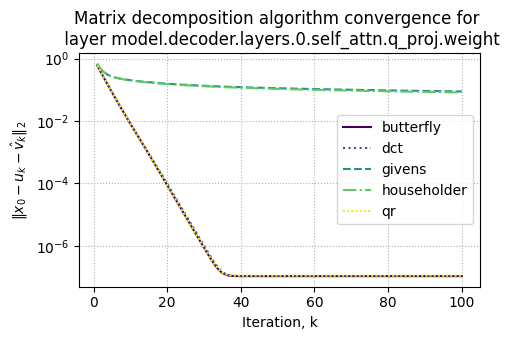

In [78]:
import pandas as pd
import seaborn as sns
sns.reset_orig()

# Explicitly define the column order to ensure consistency
columns = ['Q', 'seed', 'convergence', 'u', 'Qv', 'iteration']

# Create the DataFrame using the defined columns
data_df = pd.DataFrame(data, columns=columns)

import matplotlib.pyplot as plt
import numpy as np

# Proceed with the rest of the plotting code as is, using data_df instead of data
grouped = data_df.groupby(['Q', 'iteration']).agg(
    mean_convergence=('convergence', 'mean'),
    std_convergence=('convergence', 'std')
).reset_index()

plt.figure(figsize=(5, 3.5))

# Plot for each method
methods = grouped['Q'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))
lss = ["-", ":", "--", "-.", (0, (1, 1))]
for method, color, ls in zip(methods, colors, lss):
    method_data = grouped[grouped['Q'] == method]
    plt.semilogy(method_data['iteration'], method_data['mean_convergence'], label=method, color=color, linestyle=ls)

plt.xlabel('Iteration, k')
plt.ylabel(r'$\|x_0 - u_k - \hat{v}_k\|_2$')
plt.title(f'Matrix decomposition algorithm convergence for \n layer {layer_name}')  # Ensure layer_name is defined or replace this with a static string
plt.legend()
plt.grid(True, ls=":")
plt.tight_layout()

if layer_name == "model.decoder.layers.0.fc1.weight":
    plt.savefig('slow_layer_convergence.pdf', dpi=300)
    plt.show()
elif layer_name == "model.decoder.layers.0.self_attn.q_proj.weight":
    plt.savefig('fast_layer_convergence.pdf', dpi=300)
    plt.show()